In [ ]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

LSTM on historical Normal river levels

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving levelmain.csv to levelmain.csv


In [ ]:
# Load dataset
river_data = pd.read_csv('levelmain.csv')

In [ ]:
river_data.head()

,date,time,level
0,01-Jan-79,06:00:00,1.00
1,01-Jan-79,18:00:00,0.96
2,02-Jan-79,06:00:00,0.92
3,02-Jan-79,18:00:00,0.92
4,03-Jan-79,06:00:00,1.06


In [ ]:
river_data = river_data[['date', 'level']]

In [ ]:
river_data.head()

,date,level
0,01-Jan-79,1.00
1,01-Jan-79,0.96
2,02-Jan-79,0.92
3,02-Jan-79,0.92
4,03-Jan-79,1.06


In [ ]:
# Preprocess: Drop 'time', aggregate by date, and interpolate missing values
river_data['date'] = pd.to_datetime(river_data['date'])
river_data.set_index('date', inplace=True)

<ipython-input-15-9ba08bfd686b>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  river_data['date'] = pd.to_datetime(river_data['date'])


In [ ]:
river_data = river_data.groupby('date').mean().reset_index()
river_data.set_index('date', inplace=True)
river_datadata = river_data.resample('D').mean()

In [ ]:
river_data.head()

,level
date,
1979-01-01,0.980000
1979-01-02,0.920000
1979-01-03,1.060000
1979-01-04,1.010000
1979-01-05,1.536667


In [ ]:
river_data.shape

(14110, 1)

In [ ]:
# Create a complete date range from the start to the end of the dataset
full_date_range = pd.date_range(start=river_data.index.min(), end=river_data.index.max(), freq='D')

# Check for missing dates by comparing the full date range to the existing dates in the dataset
missing_dates = full_date_range.difference(river_data.index)

missing_dates

DatetimeIndex(['1989-08-22', '1989-08-23', '1989-08-24', '1989-08-25',
               '1989-08-26', '1989-08-27', '1989-08-28', '1989-08-29',
               '1989-08-30', '1989-08-31',
               ...
               '2011-02-19', '2011-02-20', '2011-02-21', '2011-02-22',
               '2011-02-23', '2011-02-24', '2011-02-25', '2011-02-26',
               '2011-02-27', '2011-02-28'],
              dtype='datetime64[ns]', length=865, freq=None)

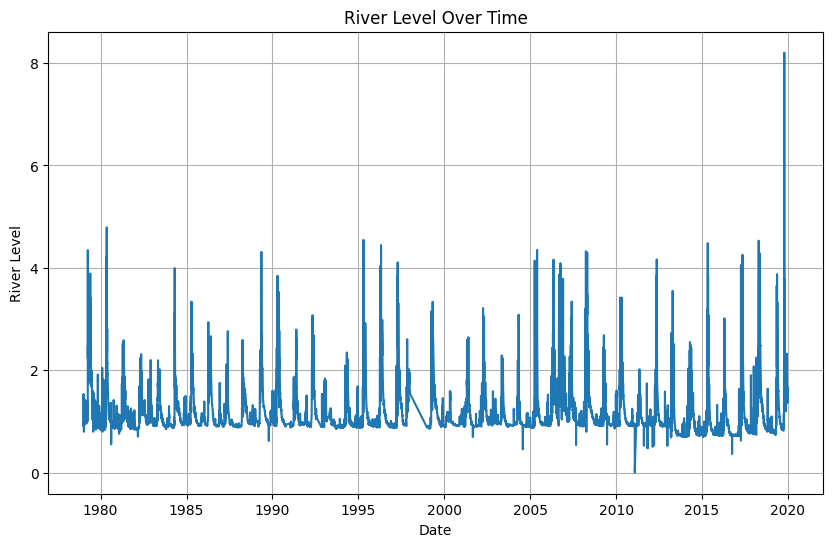

In [ ]:
import matplotlib.pyplot as plt

# Plot the level data over time
plt.figure(figsize=(10,6))
plt.plot(river_data.index, river_data['level'], label='River Level')
plt.xlabel('Date')
plt.ylabel('River Level')
plt.title('River Level Over Time')
plt.grid(True)
plt.show()


In [ ]:
river_data.shape

(14110, 1)

In [ ]:
# Reindex data to include all dates in the range
river_data = river_data.reindex(full_date_range)
river_data.index.name = 'date'

In [ ]:
river_data.shape

(14975, 1)

In [ ]:
river_data.head()

,level
date,
1979-01-01,0.980000
1979-01-02,0.920000
1979-01-03,1.060000
1979-01-04,1.010000
1979-01-05,1.536667


In [ ]:
river_data['level'] = river_data['level'].interpolate(method='pchip')

In [ ]:
river_data = river_data[river_data['level'] <= 4]

In [ ]:
river_data.describe()

,level
count,14949.000000
mean,1.119345
std,0.406010
min,0.000000
25%,0.920000
50%,0.966667
75%,1.180000
max,4.000000


In [ ]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds(42)

In [ ]:
river_data.shape

(14949, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize scaler for the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))

# Apply scaling on the 'level' column
river_data['level_scaled'] = scaler.fit_transform(river_data['level'].values.reshape(-1, 1))

# Create sequences using scaled data
sequence_length = 7  # 7-day look-back
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(river_data['level_scaled'].values, sequence_length)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11953, 7), (11953,), (2989, 7), (2989,))

In [ ]:
# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the baseline LSTM model
baseline_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)  # Output layer
])

# Compile the model with smaller learning rate
baseline_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True
)

# Train the model with early stopping
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
baseline_test_loss = baseline_model.evaluate(X_test, y_test, verbose=1)

# Print test loss
print(f"Baseline Model with Smaller Learning Rate and Early Stopping - Test Loss (MSE): {baseline_test_loss}")



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0447 - val_loss: 0.0056
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Generate predictions
baseline_predictions_scaled = baseline_model.predict(X_test)
baseline_predictions = scaler.inverse_transform(baseline_predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE and RMSE
mae_baseline = mean_absolute_error(y_test_original, baseline_predictions)
rmse_baseline = np.sqrt(mean_squared_error(y_test_original, baseline_predictions))

print(f"Baseline Model with Smaller Learning Rate and Early Stopping - Mean Absolute Error (MAE): {mae_baseline:.4f}")
print(f"Baseline Model with Smaller Learning Rate and Early Stopping - Root Mean Squared Error (RMSE): {rmse_baseline:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Baseline Model with Smaller Learning Rate and Early Stopping - Mean Absolute Error (MAE): 0.0872
Baseline Model with Smaller Learning Rate and Early Stopping - Root Mean Squared Error (RMSE): 0.2005


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Save the model
model = baseline_model
model.save('baseline_model.h5')


In [ ]:
# Load the saved LSTM model
from tensorflow.keras.models import load_model

model = load_model('baseline_model.h5')


load evaluation data from sensor

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Cleaned_New_Validation_Data_for_Evaluation.csv to Cleaned_New_Validation_Data_for_Evaluation.csv


In [ ]:
new_validation_cleaned = pd.read_csv('Cleaned_New_Validation_Data_for_Evaluation.csv')

In [ ]:
new_validation_cleaned.head()

,Unnamed: 0,time,level
0,0,2022-04-01 00:00:00+00:00,1.92
1,1,2022-04-02 00:00:00+00:00,1.93
2,6,2022-04-07 00:00:00+00:00,1.86
3,8,2022-04-09 00:00:00+00:00,1.84
4,9,2022-04-10 00:00:00+00:00,1.84


In [ ]:
river_data_validation = new_validation_cleaned.drop(columns=["Unnamed: 0"])

# Display the first few rows of the cleaned data
river_data_validation.head()


,time,level
0,2022-04-01 00:00:00+00:00,1.92
1,2022-04-02 00:00:00+00:00,1.93
2,2022-04-07 00:00:00+00:00,1.86
3,2022-04-09 00:00:00+00:00,1.84
4,2022-04-10 00:00:00+00:00,1.84


In [ ]:
river_data_validation.shape

(274, 1)

In [ ]:
# Convert the 'time' column to datetime format
river_data_validation['time'] = pd.to_datetime(river_data_validation['time'])

# Set the 'time' column as the index to work with the dates
river_data_validation.set_index('time', inplace=True)

# Create a complete date range for the given time period
full_new_date_range = pd.date_range(start=river_data_validation.index.min(), end=river_data_validation.index.max(), freq='D')

# Reindex the data to include the missing dates
new_data_full = river_data_validation.reindex(full_new_date_range)

# Use PCHIP interpolation to fill in the missing level values
new_data_full['level'] = new_data_full['level'].interpolate(method='pchip')

# Display the updated data after interpolation
new_data_full.head()

,level
2022-04-01 00:00:00+00:00,1.920000
2022-04-02 00:00:00+00:00,1.930000
2022-04-03 00:00:00+00:00,1.924543
2022-04-04 00:00:00+00:00,1.910830
2022-04-05 00:00:00+00:00,1.892845


In [ ]:
new_data_full.shape

(370, 1)

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_new_data = scaler.fit_transform(new_data_full[['level']])

In [ ]:
# Create sequences for LSTM input (7 days look-back)
sequence_length = 7
X_new = []
y_new = []

for i in range(sequence_length, len(scaled_new_data)):
    X_new.append(scaled_new_data[i-sequence_length:i, 0])
    y_new.append(scaled_new_data[i, 0])

X_new, y_new = np.array(X_new), np.array(y_new)

# Reshape the input data to 3D format (samples, timesteps, features)
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

In [ ]:
# Evaluate the model with the new validation data
loss = model.evaluate(X_new, y_new, verbose=0)

print(f'Model Evaluation Loss on New Validation Data: {loss}')


Model Evaluation Loss on New Validation Data: 0.009106309153139591


In [ ]:
# Make predictions on the new validation data
predictions = model.predict(X_new)
predictions = scaler.inverse_transform(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [ ]:
# Inverse transform the actual values
y_new_rescaled = scaler.inverse_transform(y_new.reshape(-1, 1))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inverse transform the true values
y_new_rescaled = scaler.inverse_transform(y_new.reshape(-1, 1))
(Mean Absolute Error)
mae = mean_absolute_error(y_new_rescaled, predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_new_rescaled, predictions))

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Absolute Error (MAE): 0.0515
Root Mean Squared Error (RMSE): 0.0859


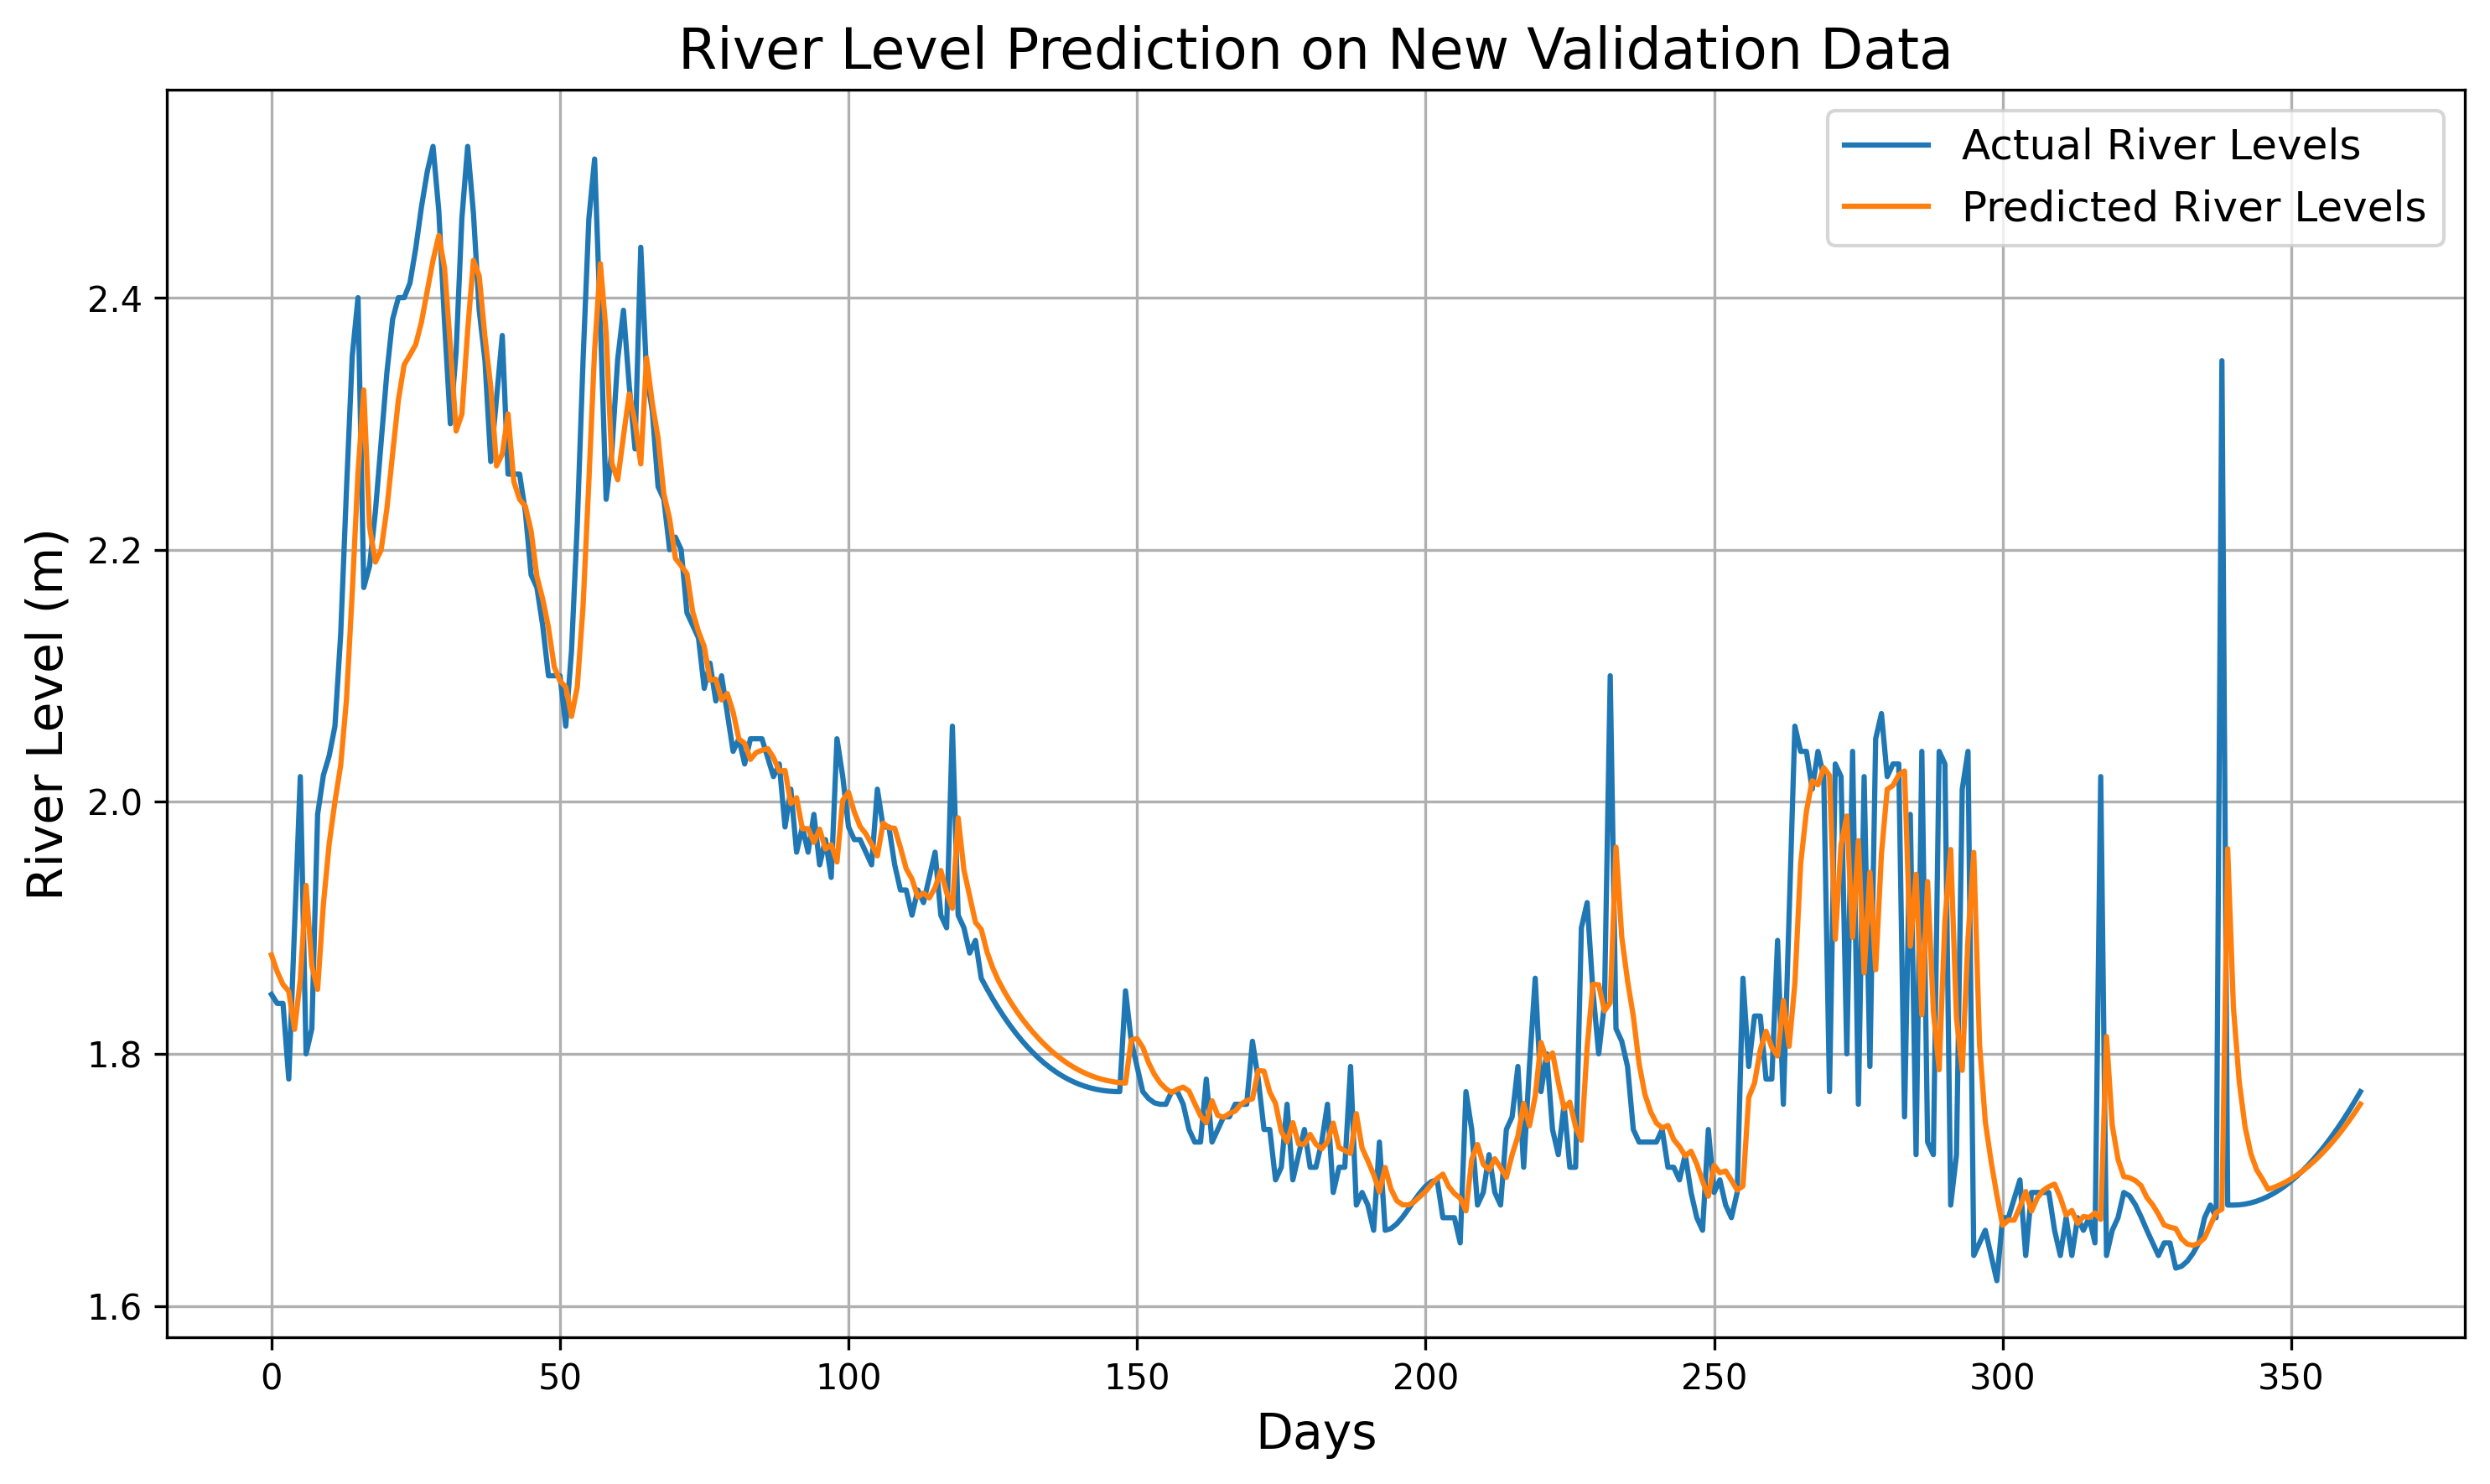

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('default')

# Plot the actual vs predicted river levels
plt.figure(figsize=(10, 6), dpi=300)

# Plot the actual and predicted river levels
plt.plot(y_new_rescaled, label='Actual River Levels')
plt.plot(predictions, label='Predicted River Levels')

# Title and labels
plt.title('River Level Prediction on New Validation Data', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('River Level (m)', fontsize=14)

plt.grid(True)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig('river_level_prediction_new_validation.png', dpi=300)

plt.show()

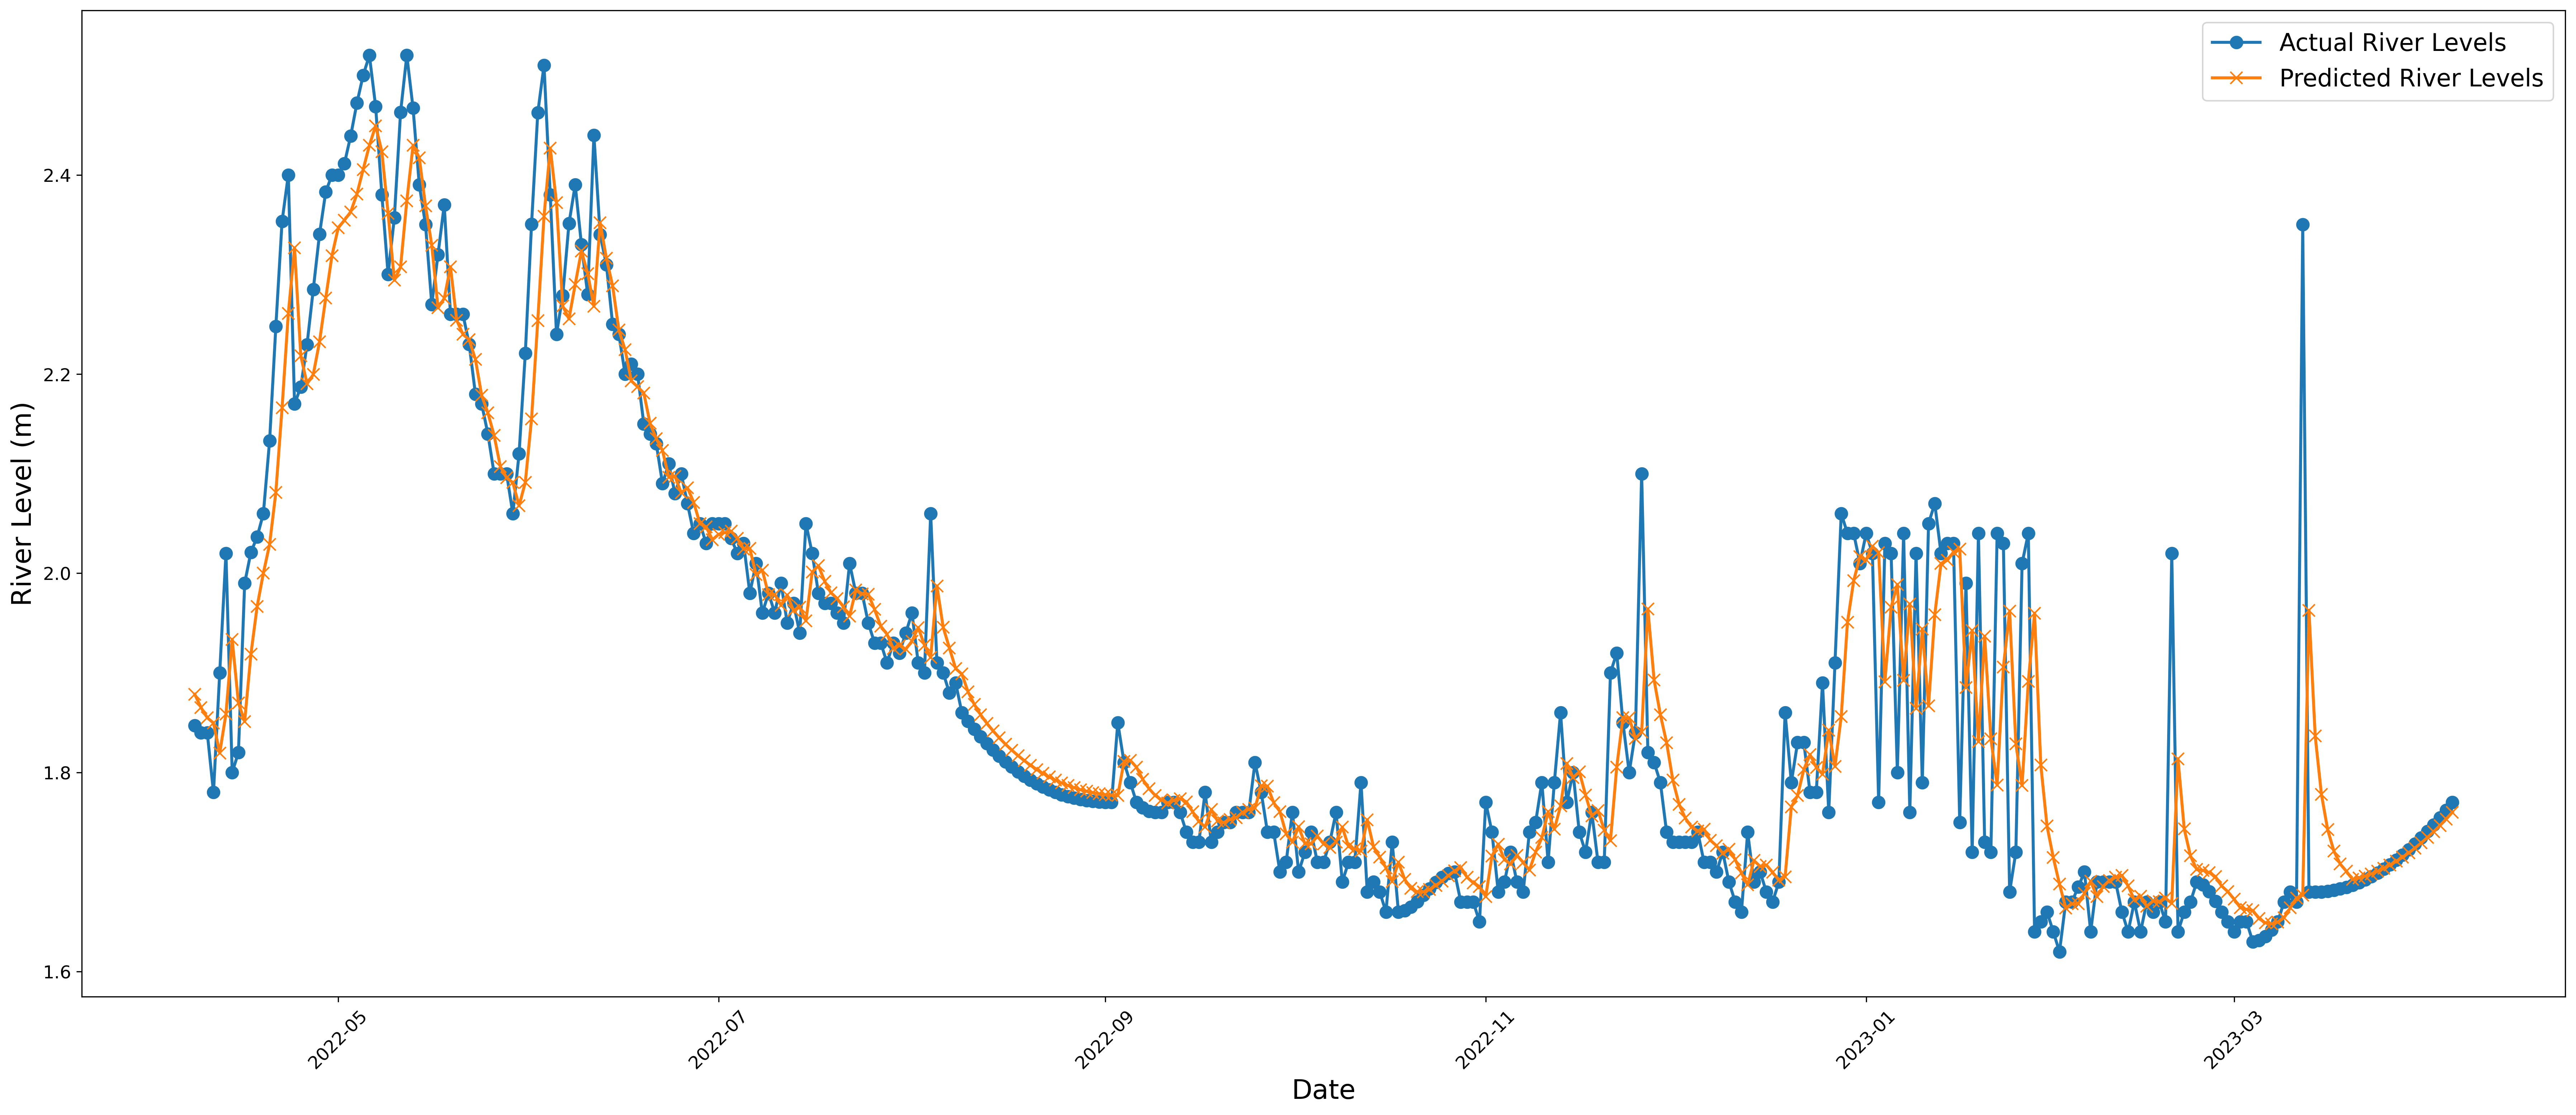

In [ ]:
import matplotlib.pyplot as plt

# Extract dates corresponding to the predictions (starting from the 8th date)
dates_for_plot = new_data_full.index[sequence_length:sequence_length + len(predictions)].values

plt.figure(figsize=(24, 10), dpi=300)

plt.style.use('default')

plt.plot(dates_for_plot, y_new_rescaled, label='Actual River Levels', marker='o', markersize=8, linewidth=2)
plt.plot(dates_for_plot, predictions, label='Predicted River Levels', marker='x', markersize=8, linewidth=2)


plt.xlabel('Date', fontsize=18)
plt.ylabel('River Level (m)', fontsize=18)

plt.grid(True, alpha=0.)

plt.legend(fontsize=16)

plt.tight_layout()

plt.savefig('river_level_prediction_new_validation_sensor.png', dpi=300)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
files.download('river_level_prediction_new_validation_sensor.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

stacked

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the stacked LSTM model with smaller learning rate and early stopping
stacked_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model with a smaller learning rate
stacked_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with early stopping
stacked_history = stacked_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0277 - val_loss: 0.0053
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 9/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 10/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 11/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 12/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - lo

In [ ]:
# Evaluate the model on the test set
test_loss = stacked_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
y_pred = stacked_model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Test Loss: 0.0024105727206915617
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Evaluate the model with the new validation data
loss = stacked_model.evaluate(X_new, y_new, verbose=0)

print(f'Model Evaluation Loss on New Validation Data: {loss}')

Model Evaluation Loss on New Validation Data: 0.0090439822524786


In [ ]:
# Make predictions on the new validation data
predictions = stacked_model.predict(X_new)
predictions = scaler.inverse_transform(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Inverse transform the actual values
y_new_rescaled = scaler.inverse_transform(y_new.reshape(-1, 1))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


y_new_rescaled = scaler.inverse_transform(y_new.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_new_rescaled, predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_new_rescaled, predictions))

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


Mean Absolute Error (MAE): 0.0510
Root Mean Squared Error (RMSE): 0.0856


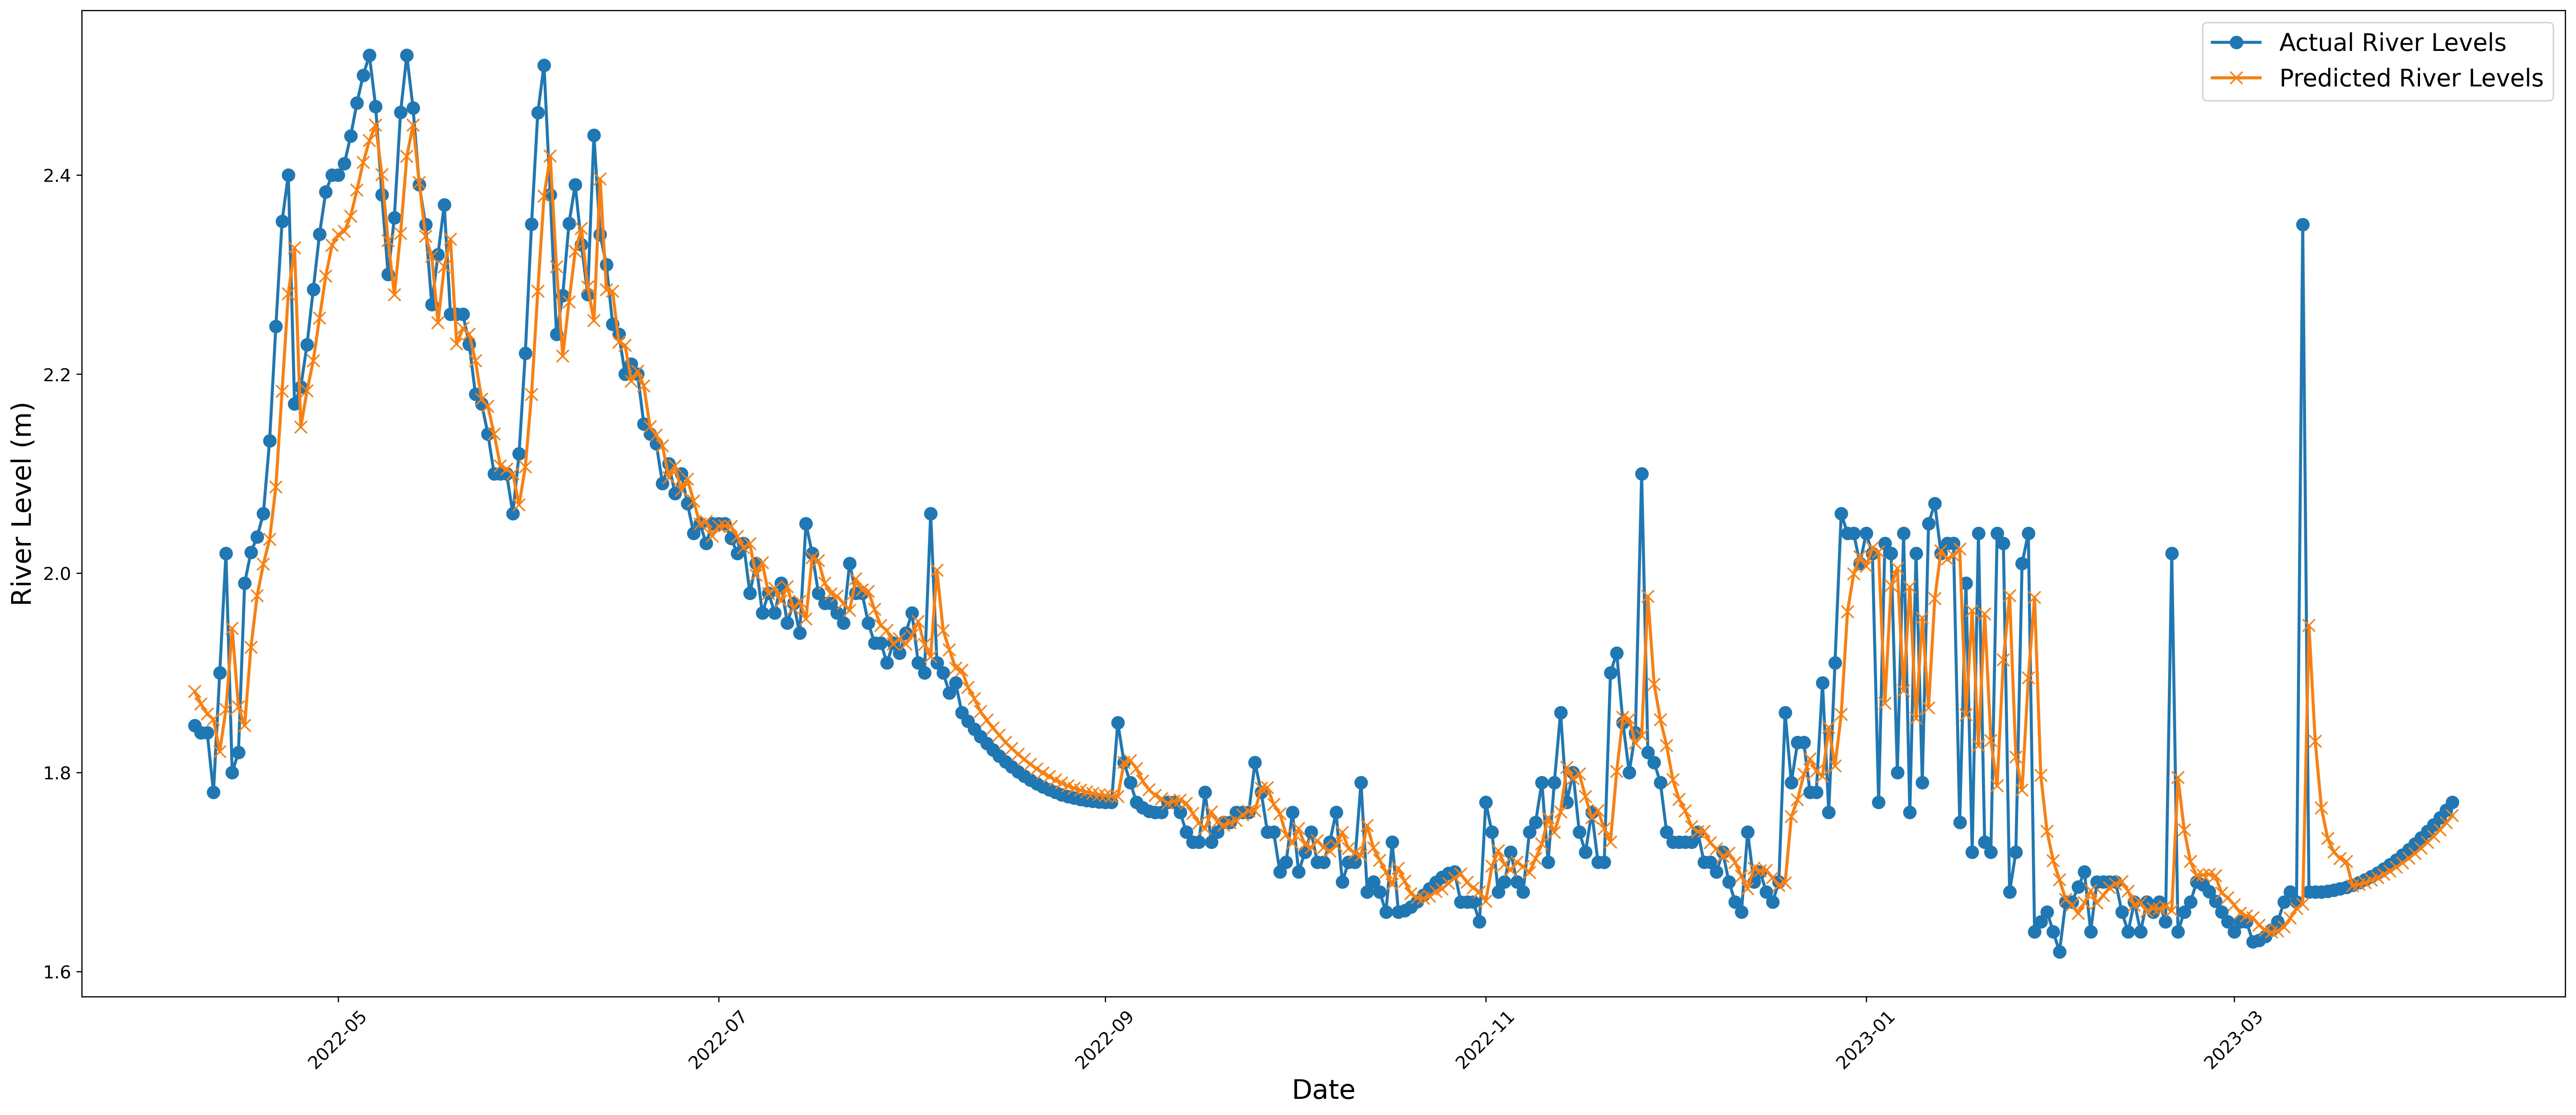

In [ ]:
import matplotlib.pyplot as plt

# Extract dates corresponding to the predictions (starting from the 8th date)
dates_for_plot = new_data_full.index[sequence_length:sequence_length + len(predictions)].values

plt.figure(figsize=(24, 10), dpi=300)

plt.style.use('default')

plt.plot(dates_for_plot, y_new_rescaled, label='Actual River Levels', marker='o', markersize=8, linewidth=2)
plt.plot(dates_for_plot, predictions, label='Predicted River Levels', marker='x', markersize=8, linewidth=2)

plt.xlabel('Date', fontsize=18)
plt.ylabel('River Level (m)', fontsize=18)

plt.grid(True, alpha=0.)

plt.legend(fontsize=16)

plt.tight_layout()

plt.savefig('river_level_prediction_new_validation_sensor.png', dpi=300)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()